In [1]:
import pandas as pd
billboard = pd.read_csv("./datasets/billboard100.csv")
summer0010s = pd.read_csv("./datasets/summer0010s.csv")

In [2]:
f1980 = pd.read_csv("./datasets/1990s.csv")
f1990 = pd.read_csv("./datasets/1990s.csv")
f2000 = pd.read_csv("./datasets/2000s.csv")
f2010 = pd.read_csv("./datasets/2010s.csv")

In [3]:
keys = {0:'C', 1:'C#/Db', 2:'D', 3:'D#/Eb', 4:'E', 5:'F', 6:'F#/Gb', 7:'G', 8:'G#/Ab', 9:'A', 10:'A#/Bb', 11:'B', 12:'C'}
import re

In [4]:
from functools import reduce
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from pandas.tools.plotting import autocorrelation_plot
#!pip install -U seaborn
pd.options.display.max_rows = 1200
pd.options.display.max_columns = 500
pd.options.display.float_format = '{:,.3f}'.format

In [5]:
# Where to save the figures
import os
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "billboard"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "img", CHAPTER_ID)


def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [6]:
def name_slicer(name):
    repls = {'X ' : 'Featuring', 'x ' : 'Featuring', '&' : 'Featuring', '+':'Featuring', ',':'Featuring', 'Feat.':'Featuring','With':'Featuring'}
    if name in ['Earth, Wind & Fire','Blood, Sweat & Tears']:
        pass
    else:
        name = reduce(lambda a, kv: a.replace(*kv), repls.items(), name)
        if 'Featuring' in name:
            name = name[:name.find("Featuring")-1]
    return name

def get_featuring(name):
    repls = {'X' : '|', 'x' : '|', '&' : '|', '+':'|', ',':'|', 'Feat.':'|','With':'|','Featuring':'|'}
    if name in ['Earth, Wind & Fire','Blood, Sweat & Tears']:
        pass
    else:
        name = reduce(lambda a, kv: a.replace(*kv), repls.items(), name)
        if '|' in name:
            name = name[2+name.find("|"):]
    return name
def get_Season(month):
    if month in (1,2,11,12):
        season = 'winter'
    elif month in (3,4,5):
        season = 'spring'
    elif month in (6,7,8):
        season = 'summer'
    else:
        season = 'autumn'
    return season
def seasonal_tops(season='winter', top_x = 11, rank =10, peak_rank=5, weeks_on_chart = 12, min_date = '1958-08-16', max_date = '2019-04-13'):
    df_season = billboard.groupby('season').get_group(season)
    temp_season = df_season.loc[df_season['rank'] <= rank, :].loc[df_season['weeks_on_chart'] >= 3, :]
    temp_season_time =  temp_season.loc[df_season['date_'] >= min_date, :].loc[temp_season['date_'] <= max_date, :]
    temp_season_time = temp_season_time[['title', 'artist','unique']] 
    temp_season_time['unique'] = temp_season_time['unique'].str.replace('|', ' - ', regex=False)
    temp_season_time_cnt = temp_season_time['unique'].value_counts().to_frame().reset_index()
    temp_season_time_cnt.columns = ['track', 'counts']

    return temp_season_time_cnt

In [7]:
billboard.replace('-',np.nan,inplace=True)
billboard['artist1'] = billboard['artist'].apply(lambda x: name_slicer(x))
billboard['featuring'] = billboard['artist'].apply(lambda x: get_featuring(x))
billboard.last_week_rank = billboard['last_week_rank'].astype('float64')
billboard['rank_delta'] = billboard.last_week_rank - billboard['rank']
billboard['year'] = pd.DatetimeIndex(billboard['date_']).year
billboard['month'] = pd.DatetimeIndex(billboard['date_']).month
billboard['week'] = pd.DatetimeIndex(billboard['date_']).week
billboard['unique'] = billboard.artist + '|' + billboard.title
billboard['season'] = billboard['month'].apply(get_Season)

In [8]:
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.tools import FigureFactory as ff
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

#jupyter setup
init_notebook_mode(connected=True)

In [9]:
#initilizing f1980a dataframe: Billboard + Spotify
bill1980 = billboard.loc[billboard['date_'] >= '1980-01-01', :].loc[billboard['date_'] <= '1989-12-31', :]
f1980a = bill1980.merge(f1980, left_on ='unique', right_on = 'unique', how='inner')
f1980a['decade'] = '1980s'
#initilizing f1990a dataframe: Billboard + Spotify
bill1990 = billboard.loc[billboard['date_'] >= '1990-01-01', :].loc[billboard['date_'] <= '1999-12-31', :]
f1990a = bill1990.merge(f1990, left_on ='unique', right_on = 'unique', how='inner')
f1990a['decade'] = '1990s'
#initilizing f2000a dataframe: Billboard + Spotify
bill2000 = billboard.loc[billboard['date_'] >= '2000-01-01', :].loc[billboard['date_'] <= '2009-12-31', :]
f2000a = bill2000.merge(f2000, left_on ='unique', right_on = 'unique', how='inner')
f2000a['decade'] = '2000s'
#initilizing f2010a dataframe: Billboard + Spotify
bill2010 = billboard.loc[billboard['date_'] >= '2010-01-01', :].loc[billboard['date_'] <= '2019-4-13', :]
f2010a = bill2010.merge(f2010, left_on ='unique', right_on = 'unique', how='inner')
f2010a['decade'] = '2010s'

In [10]:
#f1980a + f1990a + f2000a
temp = f1980a.append(f1990a).sort_values(by='date_').reset_index().drop(['index'],axis=1)
f80_00a = temp.append(f2000a).sort_values(by='date_').reset_index().drop(['index'],axis=1)
f80_10a = f80_00a.append(f2010a).sort_values(by='date_').reset_index().drop(['index'],axis=1)

In [47]:
#### ANALYSIS 2

# Billboard Top Artist Award Validation Table 1
print(billboard.loc[billboard['date_'] >= '2017-04-08', :].loc[billboard['date_'] <= '2018-03-31', :].artist1.value_counts()[:5])


Kendrick Lamar     166
Post Malone        122
Drake              109
Ed Sheeran         101
Imagine Dragons    100
Name: artist1, dtype: int64


rank               peak_rank  \
                                            count median   mean       min   
artist1          title                                                      
Bruno Mars       That's What I Like            42  7.500 15.381     1.000   
Camila Cabello   Havana                        31  4.000 21.677     1.000   
Cardi B          Bodak Yellow (Money Moves)    34  8.500 16.147     1.000   
DJ Khaled        I'm The One                   22  3.500 11.227     1.000   
                 Wild Thoughts                 21  4.000 12.810     2.000   
Ed Sheeran       Perfect                       27  3.000 14.296     1.000   
                 Shape Of You                  48 12.000 13.417     1.000   
French Montana   Unforgettable                 41 17.000 22.439     3.000   
Imagine Dragons  Believer                      45 16.000 20.067     4.000   
                 Thunder                       46 20.000 34.826     4.000   
Kendrick Lamar   Humble.                       37 14.000 19.486     1.000   
Luis Fonsi       Despacito                     42  4.500 13.095     1.000   
Post Malone      Rockstar                      26  2.000  4.038     1.000   
Sam Smith        Too Good At Goodbyes          23  8.000 12.826     4.000   
The Chainsmokers Something Just Like This      35 15.000 18.400     3.000   

                                            weeks_on_chart  
                                                       max  
artist1          title                                      
Bruno Mars       That's What I Like                 52.000  
Camila Cabello   Havana                             32.000  
Cardi B          Bodak Yellow (Money Moves)         35.000  
DJ Khaled        I'm The One                        22.000  
                 Wild Thoughts                      21.000  
Ed Sheeran       Perfect                            30.000  
                 Shape Of You                       59.000  
French Montana   Unforgettable                      42.000  
Imagine Dragons  Believer                           52.000  
                 Thunder                            47.000  
Kendrick Lamar   Humble.                            37.000  
Luis Fonsi       Despacito                          52.000  
Post Malone      Rockstar                           27.000  
Sam Smith        Too Good At Goodbyes               24.000  
The Chainsmokers Something Just Like This           39.000

In [52]:
# Billboard Top Artist Award Validation Table 2
award_2018 = billboard.loc[billboard['date_'] >= '2017-04-08', :].loc[billboard['date_'] <= '2018-03-31', :]
s = award_2018.loc[award_2018['rank']<=10,:].unique.value_counts()[:10]
testing = award_2018.loc[award_2018['unique'].isin(s.index.values)]
testing.groupby(['artist1','title']).agg({'rank':['count','median','mean'],'peak_rank':['min'],'weeks_on_chart':['max']})

rank               peak_rank  \
                                           count median   mean       min   
artist1         title                                                      
Bruno Mars      That's What I Like            42  7.500 15.381     1.000   
Camila Cabello  Havana                        31  4.000 21.677     1.000   
Cardi B         Bodak Yellow (Money Moves)    34  8.500 16.147     1.000   
Ed Sheeran      Perfect                       27  3.000 14.296     1.000   
                Shape Of You                  48 12.000 13.417     1.000   
French Montana  Unforgettable                 41 17.000 22.439     3.000   
Imagine Dragons Thunder                       46 20.000 34.826     4.000   
Kendrick Lamar  Humble.                       37 14.000 19.486     1.000   
Luis Fonsi      Despacito                     42  4.500 13.095     1.000   
Post Malone     Rockstar                      26  2.000  4.038     1.000   

                                           weeks_on_chart  
                                                      max  
artist1         title                                      
Bruno Mars      That's What I Like                 52.000  
Camila Cabello  Havana                             32.000  
Cardi B         Bodak Yellow (Money Moves)         35.000  
Ed Sheeran      Perfect                            30.000  
                Shape Of You                       59.000  
French Montana  Unforgettable                      42.000  
Imagine Dragons Thunder                            47.000  
Kendrick Lamar  Humble.                            37.000  
Luis Fonsi      Despacito                          52.000  
Post Malone     Rockstar                           27.000

In [53]:
j = []
for i in testing.week:
    if i <= 13:
        j.append(i + 39)
    else:
        j.append(i - 13)
testing.week = np.asarray(j)


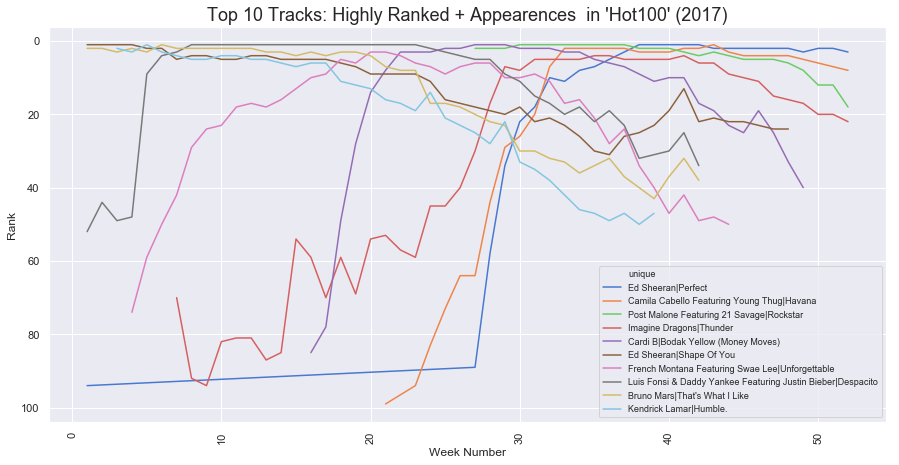

In [54]:
# 2018 top 10 tracks
a = billboard[(billboard['year']==2018)]['unique'].value_counts()[:10]
top1018 = billboard[(billboard['unique'].isin(a.index.values)) & (billboard['year']==2018)]



import calendar
sns.set(rc={'figure.figsize':(15,7.27)})
ax = sns.lineplot(x="week", y='rank', hue='unique', data=testing, palette="muted")
plt.gca().invert_yaxis()

#logit
plt.title("Top 10 Tracks: High Ranked 2017-04-08- 2018-03-31", fontsize=18)
plt.xlabel('Week Number')
plt.ylabel('Rank')
plt.legend(loc='best', fontsize=9)
plt.xticks(rotation=90)

plt.show()


Saving figure Summer_'Hot100'_2000s-2010s


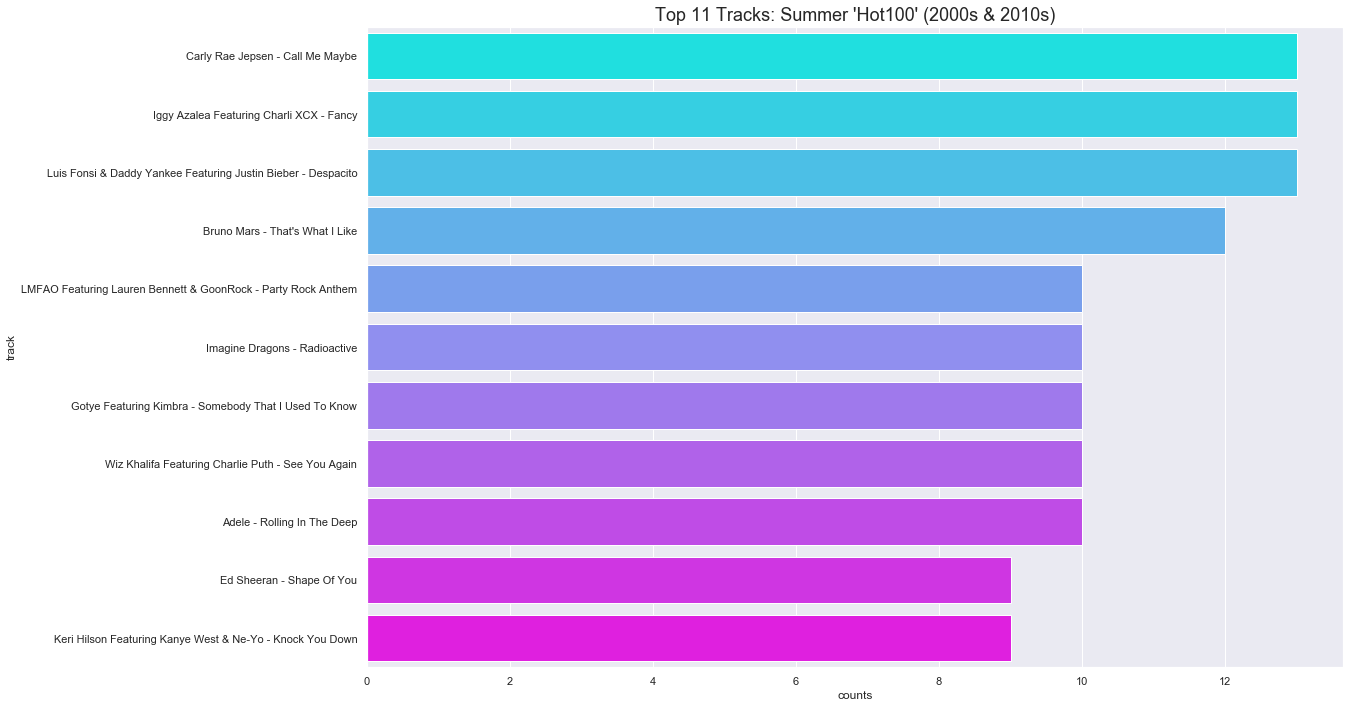

In [332]:
#### ANALYSIS 1
#Summer Chart
plt.figure(figsize = (19,10))
ax = plt.subplot(1,1,1)
sns.barplot(y = 'track', x = 'counts', data = tmp_summer_10, ax = ax, palette = plt.cm.cool(np.linspace(0,1,11)))
plt.title("Top 11 Tracks: Summer 'Hot100' (2000s & 2010s)", fontsize=18)
save_fig("Summer_'Hot100'_2000s-2010s")
plt.show()

In [1]:
# 1980s vs 1990s vs 2000s 
data = [
  go.Scatterpolar(
  r = [f1980a['danceability'].median(),f1980a['valence'].median(),f1980a['key'].median()/11,f1980a['mode'].mean()
,f1980a['tempo'].median()/200],
  theta = ['danceability','valence', 'key', 'mode', 'tempo'],
  fill = 'toself',
  name = '1980s',
  opacity = 0.9),
    
  go.Scatterpolar(
  r = [f1990a['danceability'].median(),f1990a['valence'].median(),f1990a['key'].median()/11,f1990a['mode'].mean()
,f1990a['tempo'].median()/200],
  theta = ['danceability','valence', 'key', 'mode', 'tempo'],
  fill = 'toself',
  name = '1990s',
  opacity = 0.5),
    
  go.Scatterpolar(
  r = [f2000a['danceability'].median(),f2000a['valence'].median(),f2000a['key'].median()/11,f2000a['mode'].mean() 
,f2000a['tempo'].median()/200],
  theta = ['danceability','valence', 'key', 'mode', 'tempo'],
  fill = 'toself',
  name = '2000s',
  opacity = 0.3
      
)]

layout = go.Layout(
  title = 'Progression of Chords: 1980-2009',font = dict(
      size = 15
    ),
  polar = dict(
    radialaxis = dict(
      visible = True,
      range = [0, .75]
    )
  ),
  showlegend = True
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename = "chord_")


NameError: name 'go' is not defined

In [553]:
# 1990s vs 2000s 
import plotly 
plotly.tools.set_credentials_file(username='choym92', api_key='Myh5ZJdHwzntkeXmtD4k')

data = [
   
  go.Scatterpolar(
  r = [f1990a['energy'].median(),f1990a['danceability'].median(),f1990a['valence'].median(),f1990a['key'].median()/11,f1990a['mode'].mean()
,f1990a['tempo'].median()/200],
  theta = ['energy','danceability','valence', 'key', 'mode', 'tempo'],
  fill = 'toself',
  name = '1990s',
  opacity = 1),
    
  go.Scatterpolar(
  r = [f2000a['energy'].median(),f2000a['danceability'].median(),f2000a['valence'].median(),f2000a['key'].median()/11,f2000a['mode'].mean() 
,f2000a['tempo'].median()/200],
  theta = ['energy','danceability','valence', 'key', 'mode', 'tempo'],
  fill = 'toself',
  name = '2000s',
  opacity = 1
)]

layout = go.Layout(
  title = 'Features Comparison: 1990s vs 2000s',font = dict(
      size = 15
    ),
  polar = dict(
    radialaxis = dict(
      visible = True,
      range = [0, .8]
    )
  ),
  showlegend = True
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename = "1990svs2000s")


In [511]:
top10of20y = f9000.loc[f9000['peak_rank']<=10,:].drop_duplicates('unique')

In [508]:
df=top10of20y

data = []
clusters = []
colors = ['hsl('+str(h)+',50%'+',50%)' for h in np.linspace(0, 360, 1028)]

for i in range(len(df['title'].unique())):
    name = df['title'].unique()[i]
    color = colors[i]
    x = df[ df['title'] == name ]['energy']
    y = df[ df['title'] == name ]['valence']
    z = df[ df['title'] == name ]['danceability']
    
    trace = dict(
        name = name,
        x = x, y = y, z = z,
        type = "scatter3d",    
        mode = 'markers',
        
        marker = dict(size=4, color=color, line=dict(width=0), opacity=0.7 ) )
    data.append( trace )

layout = dict(
    width=800,
    height=550,
    autosize=True,
    title="3 Features: Every Top 10 of 1990-2009",
    scene=dict(
        xaxis=dict(
            title='Energy',
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        yaxis=dict(
            title='Valence',
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        zaxis=dict(
            title='Danceability',
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        aspectratio = dict( x=1, y=1, z=0.7 ),
        aspectmode = 'manual'        
    ),
showlegend = False,
)

fig = dict(data=data, layout=layout)
iplot(fig, filename='top10_of_20-years', validate=False)


In [569]:
temp = f80_00a.replace({"key": keys})


artist_x       date_  last_week_rank  peak_rank  rank                                  title  weeks_on_chart                artist1                 featuring  rank_delta  year  month  week                                             unique  season               artist_y                                              track                                             genres  danceability  energy    key  loudness  mode  speechiness  acousticness  instrumentalness  liveness  valence   tempo            type                      id                                   uri                                         track_href                                       analysis_url  duration_ms  time_signature decade
0                                         Whitesnake  1980-08-09          84.000     74.000    74                   Fool For Your Loving           2.000             Whitesnake                Whitesnake      10.000  1980      8    32                    Whitesnake|Fool For Your Loving  summer             Whitesnake  Fool For Your Loving - Starkers Live In Tokyo,...  ['album rock', 'british blues', 'classic rock'...         0.493   0.971      A    -9.202     1        0.783         0.494             0.000     0.713    0.712 121.658  audio_features  1pxBYehIluhFy6sOOGo9GC  spotify:track:1pxBYehIluhFy6sOOGo9GC  https://api.spotify.com/v1/tracks/1pxBYehIluhF...  https://api.spotify.com/v1/audio-analysis/1pxB...       106653               4  1980s
1                                         Whitesnake  1980-08-16          74.000     64.000    64                   Fool For Your Loving           3.000             Whitesnake                Whitesnake      10.000  1980      8    33                    Whitesnake|Fool For Your Loving  summer             Whitesnake  Fool For Your Loving - Starkers Live In Tokyo,...  ['album rock', 'british blues', 'classic rock'...         0.493   0.971      A    -9.202     1        0.783         0.494             0.000     0.713    0.712 121.658  audio_features  1pxBYehIluhFy6sOOGo9GC  spotify:track:1pxBYehIluhFy6sOOGo9GC  https://api.spotify.com/v1/tracks/1pxBYehIluhF...  https://api.spotify.com/v1/audio-analysis/1pxB...       106653               4  1980s
2                                         Whitesnake  1980-08-23          64.000     58.000    58                   Fool For Your Loving           4.000             Whitesnake                Whitesnake       6.000  1980      8    34                    Whitesnake|Fool For Your Loving  summer             Whitesnake  Fool For Your Loving - Starkers Live In Tokyo,...  ['album rock', 'british blues', 'classic rock'...         0.493   0.971      A    -9.202     1        0.783         0.494             0.000     0.713    0.712 121.658  audio_features  1pxBYehIluhFy6sOOGo9GC  spotify:track:1pxBYehIluhFy6sOOGo9GC  https://api.spotify.com/v1/tracks/1pxBYehIluhF...  https://api.spotify.com/v1/audio-analysis/1pxB...       106653               4  1980s
3                                         Whitesnake  1980-08-30          58.000     54.000    54                   Fool For Your Loving           5.000             Whitesnake                Whitesnake       4.000  1980      8    35                    Whitesnake|Fool For Your Loving  summer             Whitesnake  Fool For Your Loving - Starkers Live In Tokyo,...  ['album rock', 'british blues', 'classic rock'...         0.493   0.971      A    -9.202     1        0.783         0.494             0.000     0.713    0.712 121.658  audio_features  1pxBYehIluhFy6sOOGo9GC  spotify:track:1pxBYehIluhFy6sOOGo9GC  https://api.spotify.com/v1/tracks/1pxBYehIluhF...  https://api.spotify.com/v1/audio-analysis/1pxB...       106653               4  1980s
4                                         Whitesnake  1980-09-06          54.000     54.000    54                   Fool For Your Loving           6.000             Whitesnake                Whitesnake       0.000  1980      9    36                    Whitesnake|Fool For Your Loving  autumn   

In [627]:
import plotly.plotly as py
import plotly.graph_objs as go

fig = {
  "data": [
    {
      "values": list(temp.groupby('decade').get_group('1980s')['key'].value_counts().values),
      "labels": list(temp.groupby('decade').get_group('1980s')['key'].value_counts().index.values),
      "domain": {"column": 0},
      "name": "1980s",
      "hoverinfo":"label+percent+name",
      "hole": .4,
      "type": "pie"
    },
    {
      "values": list(temp.groupby('decade').get_group('1990s')['key'].value_counts().values),
      "labels": list(temp.groupby('decade').get_group('1990s')['key'].value_counts().index.values),
      "domain": {"column": 1},
      "name": "1990s",
      "hoverinfo":"label+percent+name",
      "hole": .4,
      "type": "pie"
    },
    {
      "values": list(temp.groupby('decade').get_group('2000s')['key'].value_counts().values),
      "labels": list(temp.groupby('decade').get_group('2000s')['key'].value_counts().index.values),
      "domain": {"column": 2},
      "name": "2000s",
      "hoverinfo":"label+percent+name",
      "hole": .4,
      "type": "pie"
    },
  
  ],
  "layout": {
        "title":"Progression of Chords: Pie Charts",
        "grid": {"rows": 1, "columns": 3},
        "annotations": [
            {
                "font": {
                    "size": 20
                },
                "showarrow": False,
                "text": "1980s",
                "x": 0.11,
                "y": 0.5
            },
                    {
                "font": {
                    "size": 20
                },
                "showarrow": False,
                "text": "1990s",
                "x": 0.5,
                "y": 0.5
            },
            {
                "font": {
                    "size": 20
                },
                "showarrow": False,
                "text": "2000s",
                "x": 0.885,
                "y": 0.5
            }
        ]
    }
}
iplot(fig, filename='Progression of Chords: Pie Charts')

In [563]:
x0 = f1990a.groupby('season').get_group('winter')['energy']
x1 = f1990a.groupby('season').get_group('summer')['energy']

winter = go.Histogram(
    x=x0
)
summer = go.Histogram(
    x=x1
)
data = [winter, summer]
layout = go.Layout(barmode='group')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='stacked histogram')

In [50]:
import plotly 
plotly.tools.set_credentials_file(username='choym92', api_key='Myh5ZJdHwzntkeXmtD4k')
x = f2000['energy']
y = f2000['valence']
z = f2000['danceability']

trace1 = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
    size=4,
    color=z,
    colorscale='Viridis',
    opacity=0.5))

data = [trace1]
layout = go.Layout(
    margin=dict(
    l=0,
    r=0,
    b=0,
    t=0)
)
fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='3D_plot')


In [562]:
f80_00a.groupby(['year','key']).agg({'key':['count']})

key
         count
year key      
1980 9       7
1983 0       6
1985 5       5
1989 0      51
     1      32
     2      34
     3       7
     4      24
     5      70
     6      48
     7      79
     8      30
     9     119
     10     37
     11     66
1990 0     428
     1     457
     2     275
     3      82
     4     122
     5     378
     6     185
     7     417
     8     241
     9     324
     10    309
     11    228
1991 0     291
     1     462
     2     372
     3     150
     4     221
     5     230
     6     328
     7     379
     8     240
     9     329
     10    242
     11    206
1992 0     338
     1     389
     2     344
     3     118
     4     244
     5     270
     6     399
     7     544
     8     233
     9     331
     10    346
     11    302
1993 0     312
     1     397
     2     386
     3      40
     4     220
     5     324
     6     256
     7     458
     8     261
     9     307
     10    191
     11    331
1994 0     394
     1     203
     2     313
     3     159
     4     244
     5     295
     6     423
     7     496
     8     131
     9     445
     10    228
     11    266
1995 0     323
     1     340
     2     356
     3     112
     4     202
     5     332
     6     310
     7     577
     8     267
     9     267
     10    206
     11    438
1996 0     286
     1     332
     2     307
     3      78
     4     195
     5     299
     6     300
     7     305
     8     209
     9     294
     10    224
     11    443
1997 0     355
     1     480
     2     250
     3      92
     4     268
     5     295
     6     278
     7     408
     8     234
     9     314
     10    204
     11    325
1998 0     440
     1     454
     2     311
     3     101
     4     221
     5     141
     6     261
     7     406
     8     212
     9     272
     10    190
     11    397
1999 0     459
     1     430
     2     347
     3     240
     4     305
     5     287
     6     342
     7     492
     8     327
     9     377
     10    379
     11    277
2000 0     614
     1     555
     2     497
     3     163
     4     344
     5     221
     6     259
     7     784
     8     287
     9     595
     10    490
     11    246
2001 0     257
     1     519
     2     323
     3     175
     4     305
     5     359
     6     392
     7     458
     8     333
     9     340
     10    188
     11    286
2002 0     319
     1     394
     2     519
     3     162
     4     344
     5     299
     6     353
     7     394
     8     505
     9     356
     10    252
     11    355
2003 0     382
     1     497
     2     450
     3      79
     4     481
     5     446
     6     379
     7     271
     8     379
     9     226
     10    458
     11    240
2004 0     393
     1     455
     2     535
     3     120
     4     340
     5     298
     6     324
     7     493
     8     310
     9     440
     10    269
     11    314
2005 0     436
     1     634
     2     425
     3      76
     4     435
     5     364
     6     298
     7     511
     8     315
     9     375
     10    347
     11    332
2006 0     438
     1     447
     2     532
     3     170
     4     345
     5     362
     6     400
     7     429
     8     425
     9     401
     10    329
     11    207
2007 0     559
     1     406
     2     391
     3     173
     4     299
     5     395
     6     214
     7     473
     8     432
     9     406
     10    200
     11    320
2008 0     493
     1     508
     2     394
     3     174
     4     358
     5     369
     6     179
     7     440
     8     251
     9     397
     10    250
     11    439
2009 0     648
     1     455
     2     282
     3     106
     4     389
     5     337
     6     402
     7     276
     8     357
     9     480
     10    301
     11    465

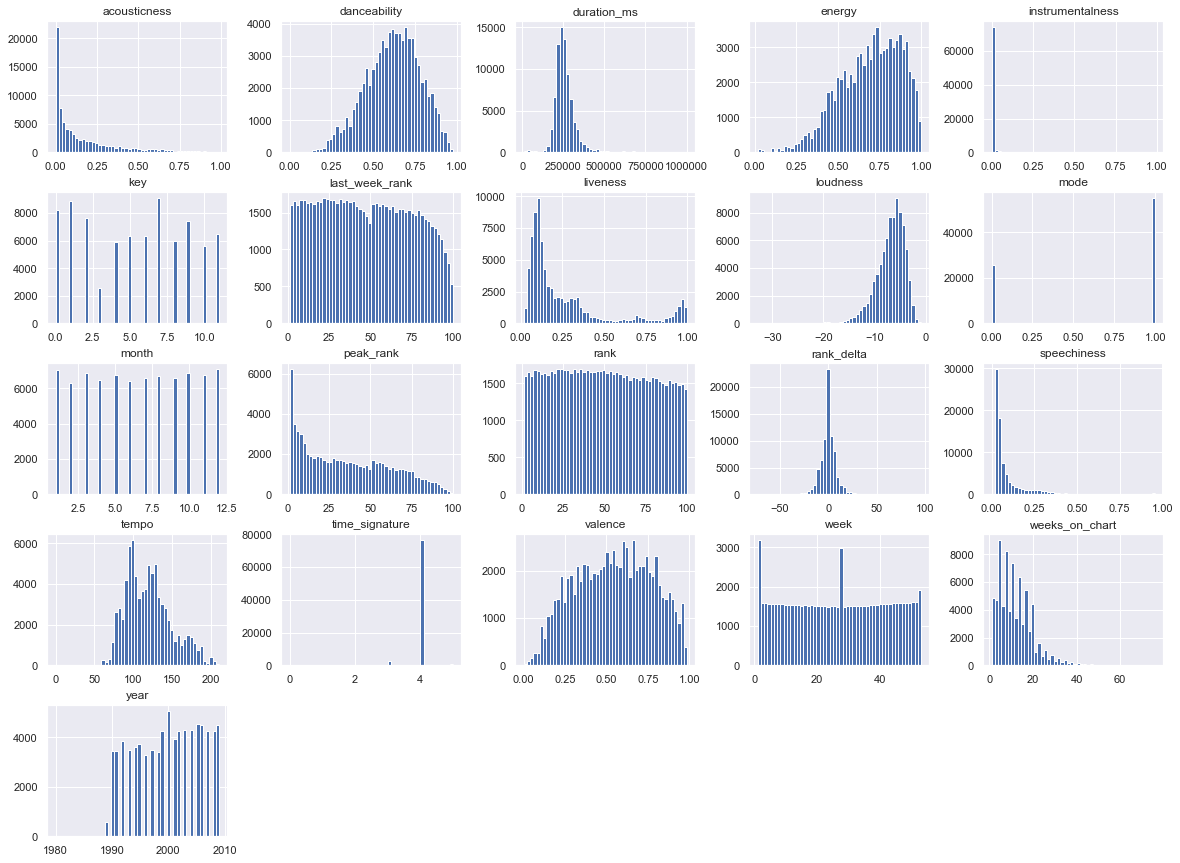

In [560]:
%matplotlib inline
import matplotlib.pyplot as plt
f80_00a.hist(bins=50, figsize=(20,15))
plt.show()

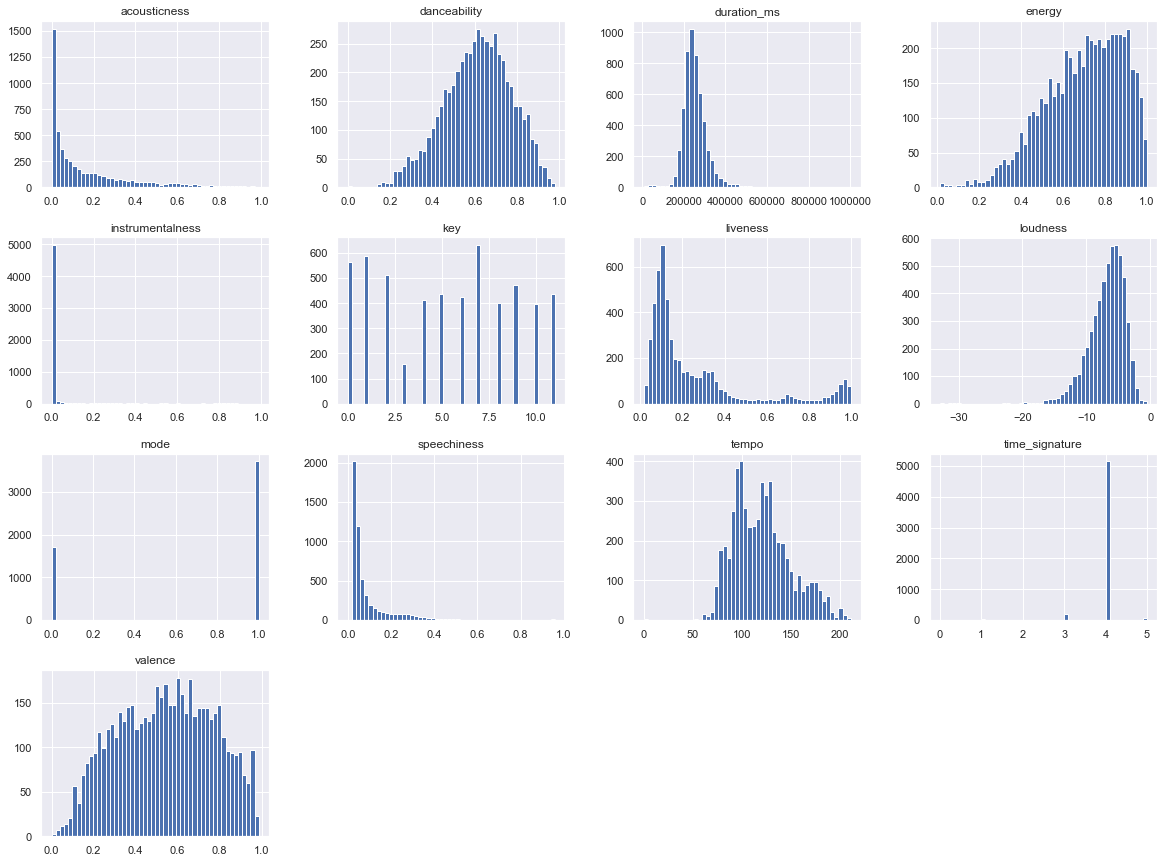

In [260]:
%matplotlib inline
import matplotlib.pyplot as plt
f2000.hist(bins=50, figsize=(20,15))
plt.show()

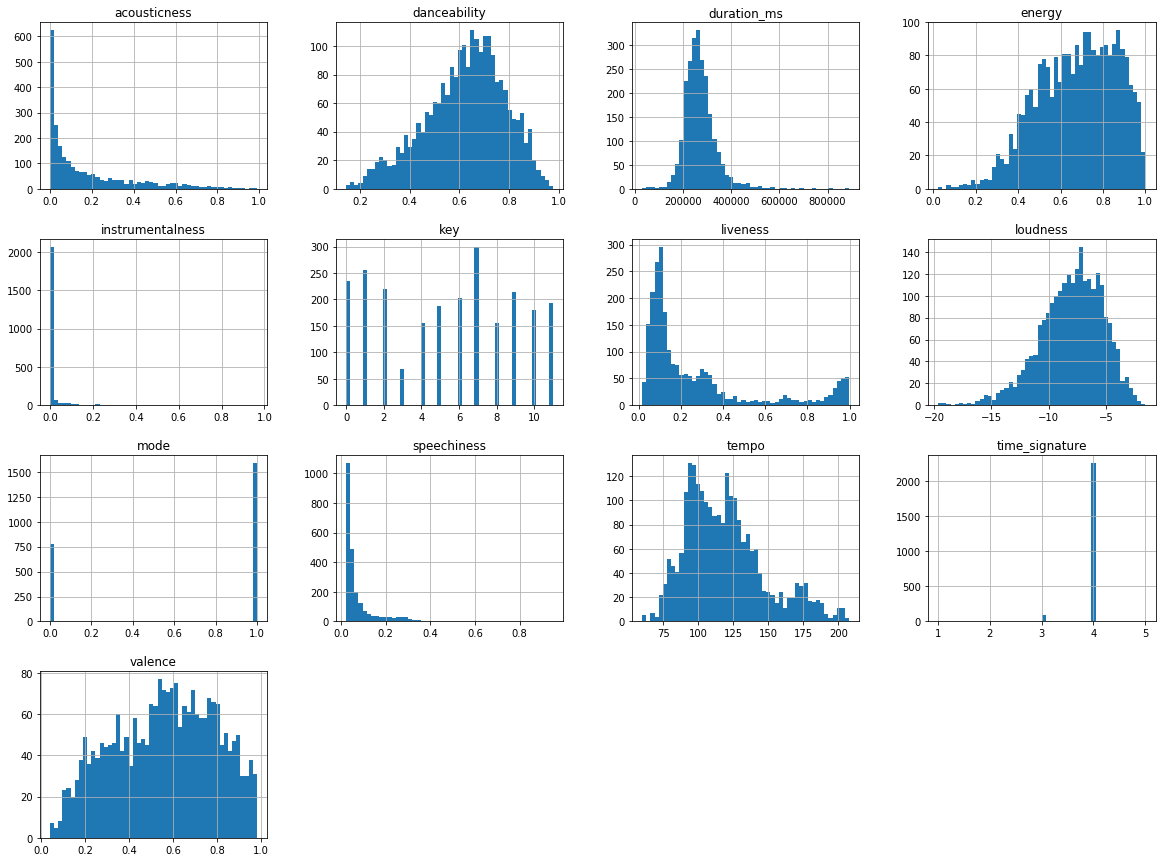

In [53]:
%matplotlib inline
import matplotlib.pyplot as plt
f1990.hist(bins=50, figsize=(20,15))
plt.show()

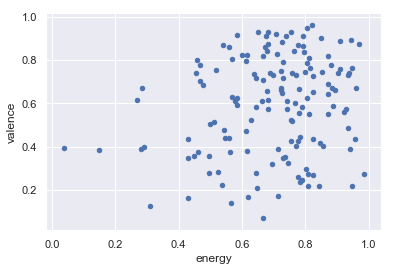

In [607]:
summer0010s.plot(kind="scatter", x="energy", y="valence", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)

In [558]:
seasonal_tops('summer',min_date = '2000-01-01')

track  counts
0                                 Nelly - Hot In Herre      14
1                        Imagine Dragons - Radioactive      14
2    Daft Punk Featuring Pharrell Williams - Get Lucky      14
3                              Coldplay - Viva La Vida      13
4                            Ed Sheeran - Shape Of You      13
5                               Fetty Wap - Trap Queen      13
6    Luis Fonsi & Daddy Yankee Featuring Justin Bie...      13
7                                  Rihanna - Needed Me      13
8    LMFAO Featuring Lauren Bennett & GoonRock - Pa...      13
9                      Bruno Mars - That's What I Like      13
10       Ariana Grande Featuring Iggy Azalea - Problem      13
11   Taylor Swift Featuring Kendrick Lamar - Bad Blood      13
12           Maroon 5 Featuring Wiz Khalifa - Payphone      13
13                                 Aaliyah - Try Again      13
14                    Carly Rae Jepsen - Call Me Maybe      13
15   The Chainsmokers Featuring Daya - Don't Let Me...      13
16            Kelly Clarkson - Behind These Hazel Eyes      13
17     Nelly Furtado Featuring Timbaland - Promiscuous      13
18                   Mariah Carey - We Belong Together      13
19            Iggy Azalea Featuring Charli XCX - Fancy      13
20   Pitbull Featuring Ne-Yo, Afrojack & Nayer - Gi...      13
21                            Nico & Vinz - Am I Wrong      13
22           Drake Featuring WizKid & Kyla - One Dance      13
23   DJ Khaled Featuring Justin Bieber, Quavo, Chan...      13
24              Vertical Horizon - Everything You Want      13
25         B.o.B Featuring Hayley Williams - Airplanes      13
26   Gotye Featuring Kimbra - Somebody That I Used ...      13
27                         Usher - Confessions Part II      13
28                                Rihanna - Take A Bow      13
29                                 Ella Mai - Boo'd Up      12
30           Cardi B, Bad Bunny & J Balvin - I Like It      12
31   Keri Hilson Featuring Kanye West & Ne-Yo - Kno...      12
32                       Gwen Stefani - Hollaback Girl      12
33                                     Cassie - Me & U      12
34                 The Black Eyed Peas - Boom Boom Pow      12
35             Beyonce Featuring Jay Z - Crazy In Love      12
36                        Katy Perry - I Kissed A Girl      12
37                            matchbox twenty - Unwell      12
38                                       MAGIC! - Rude      12
39                    Alicia Keys - If I Ain't Got You      12
40   Wiz Khalifa Featuring Charlie Puth - See You A...      12
41                         Adele - Rolling In The Deep      12
42         Justin Timberlake - Can't Stop The Feeling!      12
43                                  Joe - I Wanna Know      12
44                        Fergie - Big Girls Don't Cry      12
45                  Rihanna Featuring Jay-Z - Umbrella      12
46   Katy Perry Featuring Snoop Dogg - California G...      12
47   Robin Thicke Featuring T.I. + Pharrell - Blurr...      12
48                       Rihanna - Where Have You Been      11
49   Calvin Harris Featuring Rihanna - This Is What...      11
50     The Black Eyed Peas - Don't Phunk With My Heart      11
51                   WALK THE MOON - Shut Up And Dance      11
52   Macklemore & Ryan Lewis Featuring Ray Dalton -...      11
53                                   Desiigner - Panda      11
54       Florida Georgia Line Featuring Nelly - Cruise      11
55                        Sean Kingston - Fire Burning      11
56                     Usher Featuring will.i.am - OMG      11
57                               Drake - Nice For What      11
58            Lil' Kim Featuring 50 Cent - Magic Stick      11
59                     Lifehouse - Hanging By A Moment      11
60                             Hoobastank - The Reason      11
61                            Sam Smith - Stay With Me      11
62                  Train - Drops Of Jupiter (Tell Me)      11
63               

In [142]:

df_summer = billboard.groupby('season').get_group('summer') #Summer
# Weeks on chart >= 12. Rank <= 5
summer_10 = df_summer.loc[df_summer['rank'] <= 5, :].loc[df_summer['weeks_on_chart'] >= 12, :]
summer_102010s = summer_10.loc[df_summer['date_'] >= '2000-01-01', :]
summer_102010s = summer_102010s[['title', 'artist','unique']]
summer_102010s['unique'] = summer_102010s['unique'].str.replace('|', ' - ', regex=False)
summer_2010s_cnt_10 = summer_102010s['unique'].value_counts().to_frame().reset_index()
summer_2010s_cnt_10.columns = ['track', 'counts']
tmp_summer_10 = summer_2010s_cnt_10.iloc[np.arange(0,11),:]
tmp_summer_10.reset_index(drop=  True, inplace = True)
tmp_summer_10


track  counts
0                    Carly Rae Jepsen - Call Me Maybe      13
1            Iggy Azalea Featuring Charli XCX - Fancy      13
2   Luis Fonsi & Daddy Yankee Featuring Justin Bie...      13
3                     Bruno Mars - That's What I Like      12
4   LMFAO Featuring Lauren Bennett & GoonRock - Pa...      10
5                       Imagine Dragons - Radioactive      10
6   Gotye Featuring Kimbra - Somebody That I Used ...      10
7   Wiz Khalifa Featuring Charlie Puth - See You A...      10
8                         Adele - Rolling In The Deep      10
9                           Ed Sheeran - Shape Of You       9
10  Keri Hilson Featuring Kanye West & Ne-Yo - Kno...       9

Saving figure Summer_'Hot100'_2000s-2010s


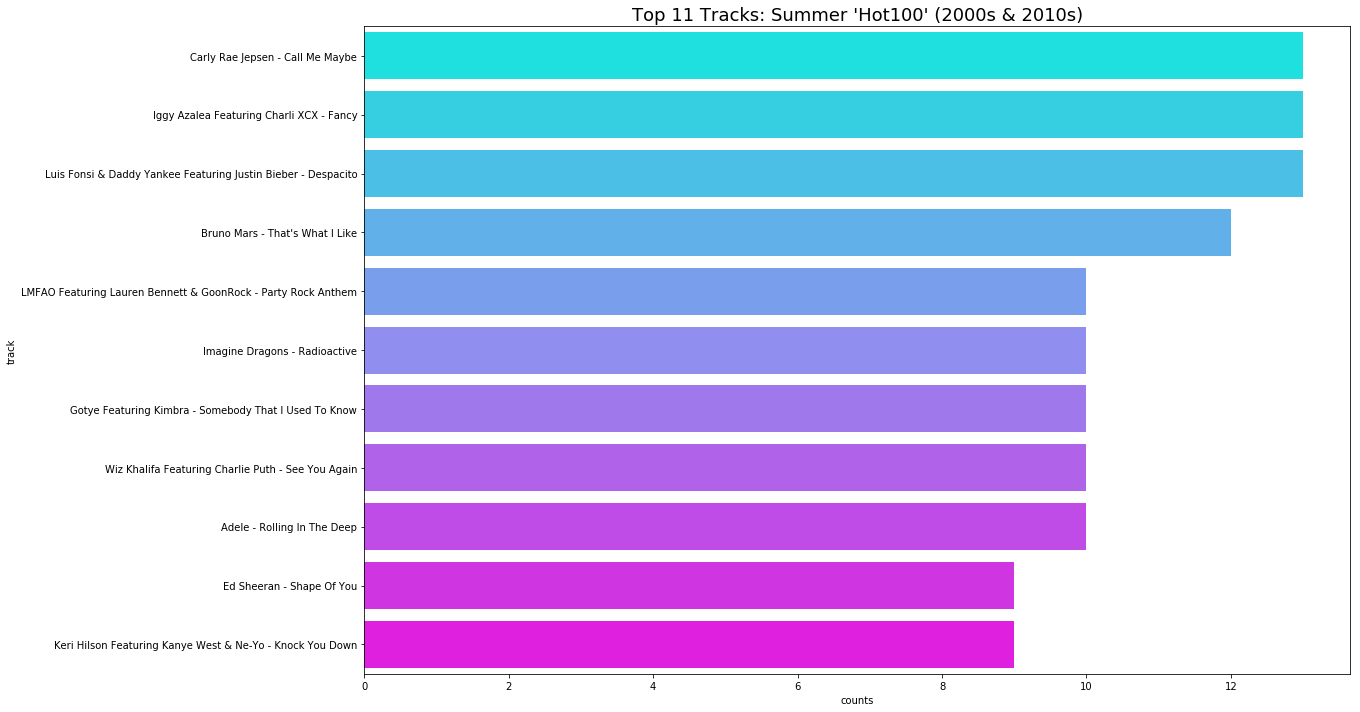

In [164]:
plt.figure(figsize = (19,10))
ax = plt.subplot(1,1,1)
sns.barplot(y = 'track', x = 'counts', data = tmp_summer_10, ax = ax, palette = plt.cm.cool(np.linspace(0,1,11)))
plt.title("Top 11 Tracks: Summer 'Hot100' (2000s & 2010s)", fontsize=18)
save_fig("Summer_'Hot100'_2000s-2010s")
plt.show()

artist                                              track  \
0                Maroon 5                                     Girls Like You   
1                  Cardi                                           I Like It   
2             Post Malone                                         Better Now   
3                   Drake                                      Nice For What   
4                Ella Mai                                           Boo'd Up   
5                   Drake                                         God's Plan   
6            XXXTENTACION                                               SAD!   
7             Post Malone                       Psycho (feat. Ty Dolla $ign)   
8              Luis Fonsi                                          Despacito   
9          French Montana                                      Unforgettable   
10        Imagine Dragons                                           Believer   
11           Charlie Puth                                          Attention   
12             Bruno Mars                                 That's What I Like   
13              DJ Khaled  I'm the One (feat. Justin Bieber, Quavo, Chanc...   
14             Ed Sheeran                                       Shape of You   
15                    Sia                                      Cheap Thrills   
16                  Drake                                          One Dance   
17              Desiigner                                              Panda   
18          Fifth Harmony               Work from Home (feat. Ty Dolla $ign)   
19           Lukas Graham                         7 Years - Spotify Sessions   
20                    OMI         Cheerleader - Felix Jaehn Remix Radio Edit   
21                Silento                                    Watch Me Part 2   
22            Major Lazer                                            Lean On   
23             The Weeknd                                          The Hills   
24           Taylor Swift                                          Bad Blood   
25              Fetty Wap                                         Trap Queen   
26          WALK THE MOON                           Shut Up and Dance - Live   
27           Jason Derulo                                    Want to Want Me   
28             The Weeknd                   Earned It (Fifty Shades Of Grey)   
29                 MAGIC!                                               Rude   
30              Sam Smith                                       Stay With Me   
31            Iggy Azalea                                              Fancy   
32          Ariana Grande                                            Problem   
33            John Legend                All of Me - Live from Spotify Milan   
34      Pharrell Williams                     Happy - From "Despicable Me 2"   
35           Robin Thicke                                      Blurred Lines   
36        Imagine Dragons                                        Radioactive   
37              Daft Punk                                          Get Lucky   
38   Florida Georgia Line                                             Cruise   
39      Justin Timberlake                                            Mirrors   
40                   P!nk           Just Give Me a Reason (feat. Nate Ruess)   
41             Bruno Mars                                When I Was Your Man   
42                Rihanna                                               Stay   
43               Flo Rida                                            Whistle   
44         Ellie Goulding                            Lights - Single Version   
45       Carly Rae Jepsen                                      Call Me Maybe   
46             Katy Perry                                         Wide Awake   
47               Maroon 5                              Payphone - Commentary   
48                  Gotye        Somebody That I Used To Know - feat. Kimbra   
49                 

In [541]:
seasonal_tops(season='summer',min_date = '2000-01-01')

track  counts
0     Jennifer Lopez Featuring Nas - I'm Gonna Be Al...      14
1                        Zedd Featuring Foxes - Clarity      14
2     Daft Punk Featuring Pharrell Williams - Get Lucky      14
3             Chad Kroeger Featuring Josey Scott - Hero      14
4                         Imagine Dragons - Radioactive      14
5          Ariana Grande Featuring Mac Miller - The Way      14
6                           Justin Timberlake - Mirrors      14
7                    Vanessa Carlton - A Thousand Miles      14
8     Robin Thicke Featuring T.I. + Pharrell - Blurr...      14
9                                  Nelly - Hot In Herre      14
10                         Jimmy Eat World - The Middle      14
11                                  Eminem - Without Me      14
12        Florida Georgia Line Featuring Nelly - Cruise      14
13    P!nk Featuring Nate Ruess - Just Give Me A Reason      14
14    Macklemore & Ryan Lewis Featuring Ray Dalton -...      14
15                                    Khalid - Location      13
16      Taio Cruz Featuring Ludacris - Break Your Heart      13
17      Nelly Furtado Featuring Timbaland - Promiscuous      13
18                      Jason Aldean - Dirt Road Anthem      13
19             One Direction - What Makes You Beautiful      13
20    Calvin Harris Featuring Rihanna - This Is What...      13
21                                         Usher - Burn      13
22                               matchbox twenty - Bent      13
23    Omarion Featuring Chris Brown & Jhene Aiko - P...      13
24                         Selena Gomez - Come & Get It      13
25              Nina Sky Featuring Jabba - Move Ya Body      13
26                       City High - What Would You Do?      13
27                                      Daughtry - Home      13
28             Iggy Azalea Featuring Charli XCX - Fancy      13
29                         Katy Perry - I Kissed A Girl      13
30                        Sheryl Crow - Soak Up The Sun      13
31                David Guetta Featuring Sia - Titanium      13
32    Fifth Harmony Featuring Ty Dolla $ign - Work F...      13
33                   Train - Drops Of Jupiter (Tell Me)      13
34                           Imagine Dragons - Believer      13
35                                  Ella Mai - Boo'd Up      13
36    The Chainsmokers Featuring Daya - Don't Let Me...      13
37                                  P!nk - There You Go      13
38                                Lloyd Banks - On Fire      13
39                                    OMI - Cheerleader      13
40                             Kanye West - Jesus Walks      13
41         Juvenile Featuring Soulja Slim - Slow Motion      13
42                                        MAGIC! - Rude      13
43    DJ Khaled Featuring Justin Bieber, Quavo, Chan...      13
44             Lil' Kim Featuring 50 Cent - Magic Stick      13
45    Taylor Swift Featuring Kendrick Lamar - Bad Blood      13
46             Kelly Clarkson - Behind These Hazel Eyes      13
47          fun. Featuring Janelle Monae - We Are Young      13
48         Post Malone Featuring Ty Dolla $ign - Psycho      13
49                              John Legend - All Of Me      13
50                              Miley Cyrus - The Climb      13
51                        Lady Antebellum - Just A Kiss      13
52                                    Drake - Controlla      13
53      Uncle Kracker Featuring Dobie Gray - Drift Away      13
54                               Weezer - Beverly Hills      13
55                                     Maroon 5 - Sugar      13
56            Katy Perry Featuring Juicy J - Dark Horse      13
57    T-Pain Featuring Yung Joc - Buy U A Drank (Sha...      13
58                            Ed Sheeran - Shape Of You      13
59                            Uncle Kracker - Follow Me      13
60        Ariana Grande Featuring Iggy Azalea - Problem      13
61                The All-American Rejects - Move Along      13
62                

In [538]:
def seasonal_tops(season='winter', top_x = 11, rank =10, peak_rank=5, weeks_on_chart = 12, min_date = '1958-08-16', max_date = '2019-04-13'):
    df_season = billboard.groupby('season').get_group(season)
    temp_season = df_season.loc[df_season['rank'] <= rank, :].loc[df_season['weeks_on_chart'] >= 3, :]
    temp_season_time =  temp_season.loc[df_season['date_'] >= min_date, :].loc[temp_season['date_'] <= max_date, :]
    temp_season_time = temp_season_time[['title', 'artist','unique']] 
    temp_season_time['unique'] = temp_season_time['unique'].str.replace('|', ' - ', regex=False)
    temp_season_time_cnt = temp_season_time['unique'].value_counts().to_frame().reset_index()
    temp_season_time_cnt.columns = ['track', 'counts']

    return temp_season_time_cnt

In [510]:
a = billboard.groupby('year').get_group(2018)
b = a.loc[a['peak_rank'] <= 10, :]
b['unique'] = b['unique'].str.replace('|', ' - ', regex=False)
b

C:\Users\Paul Cho\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


artist       date_  \
1500                                      Ariana Grande  2018-12-29   
1501                                             Halsey  2018-12-29   
1502                                       Travis Scott  2018-12-29   
1503                             Post Malone & Swae Lee  2018-12-29   
1504                              Marshmello & Bastille  2018-12-29   
1505                                Panic! At The Disco  2018-12-29   
1506                                       Mariah Carey  2018-12-29   
1507        Kodak Black Featuring Travis Scott & Offset  2018-12-29   
1508                                   Lil Baby & Gunna  2018-12-29   
1509                                      Andy Williams  2018-12-29   
1514                         Maroon 5 Featuring Cardi B  2018-12-29   
1515                                          Sheck Wes  2018-12-29   
1519                                5 Seconds Of Summer  2018-12-29   
1520                                        Post Malone  2018-12-29   
1521                          Meek Mill Featuring Drake  2018-12-29   
1522                                         Juice WRLD  2018-12-29   
1525                          Bad Bunny Featuring Drake  2018-12-29   
1536                                   Khalid & Normani  2018-12-29   
1539                      Cardi B, Bad Bunny & J Balvin  2018-12-29   
1543                         Lady Gaga & Bradley Cooper  2018-12-29   
1548                                          Lil Wayne  2018-12-29   
1600                                      Ariana Grande  2018-12-22   
1601                                             Halsey  2018-12-22   
1602                                       Travis Scott  2018-12-22   
1603                              Marshmello & Bastille  2018-12-22   
1604                                Panic! At The Disco  2018-12-22   
1605                                       Mariah Carey  2018-12-22   
1606                             Post Malone & Swae Lee  2018-12-22   
1607                                   Lil Baby & Gunna  2018-12-22   
1608        Kodak Black Featuring Travis Scott & Offset  2018-12-22   
1609                         Maroon 5 Featuring Cardi B  2018-12-22   
1611                                          Sheck Wes  2018-12-22   
1616                          Meek Mill Featuring Drake  2018-12-22   
1618                                         Juice WRLD  2018-12-22   
1619                                        Post Malone  2018-12-22   
1621                                5 Seconds Of Summer  2018-12-22   
1625                          Bad Bunny Featuring Drake  2018-12-22   
1629                                   Khalid & Normani  2018-12-22   
1637                      Cardi B, Bad Bunny & J Balvin  2018-12-22   
1638                         Lady Gaga & Bradley Cooper  2018-12-22   
1643                                          Lil Wayne  2018-12-22   
1645                              Tyga Featuring Offset  2018-12-22   
1649                                      Ariana Grande  2018-12-22   
1700                                      Ariana Grande  2018-12-15   
1701                                       Travis Scott  2018-12-15   
1702                                             Halsey  2018-12-15   
1703                              Marshmello & Bastille  2018-12-15   
1704                                Panic! At The Disco  2018-12-15   
1706                                       Mariah Carey  2018-12-15   
1707        Kodak Black Featuring Travis Scott & Offset  2018-12-15   
1708                                   Lil Baby & Gunna  2018-12-15   
1709                                          Sheck Wes  2018-12-15   
1710                         Maroon 5 Featuring Cardi B  2018-12-15   
1712                                         Juice WRLD  2018-12-15   
1713                                5 Seconds Of Summer  2018-12-15   
1714                                        Post Malone  2018-12-15   
17

In [511]:
c = b['unique'].value_counts()[:10]
a = b[(b['unique'].isin(c.index.values)) & (b['year']==2018)]
a

artist       date_  last_week_rank  \
1514           Maroon 5 Featuring Cardi B  2018-12-29            10.0   
1520                          Post Malone  2018-12-29            20.0   
1522                           Juice WRLD  2018-12-29            19.0   
1539        Cardi B, Bad Bunny & J Balvin  2018-12-29            38.0   
1609           Maroon 5 Featuring Cardi B  2018-12-22            11.0   
1618                           Juice WRLD  2018-12-22            13.0   
1619                          Post Malone  2018-12-22            15.0   
1637        Cardi B, Bad Bunny & J Balvin  2018-12-22            42.0   
1710           Maroon 5 Featuring Cardi B  2018-12-15             9.0   
1712                           Juice WRLD  2018-12-15            10.0   
1714                          Post Malone  2018-12-15            11.0   
1741        Cardi B, Bad Bunny & J Balvin  2018-12-15            31.0   
1808           Maroon 5 Featuring Cardi B  2018-12-08             8.0   
1809                           Juice WRLD  2018-12-08             5.0   
1810                          Post Malone  2018-12-08            11.0   
1830        Cardi B, Bad Bunny & J Balvin  2018-12-08            24.0   
1904                           Juice WRLD  2018-12-01             6.0   
1907           Maroon 5 Featuring Cardi B  2018-12-01             5.0   
1910                          Post Malone  2018-12-01            11.0   
1923        Cardi B, Bad Bunny & J Balvin  2018-12-01            26.0   
1944  Post Malone Featuring Ty Dolla $ign  2018-12-01            48.0   
1945                         XXXTENTACION  2018-12-01            45.0   
2004           Maroon 5 Featuring Cardi B  2018-11-24             2.0   
2005                           Juice WRLD  2018-11-24             5.0   
2010                          Post Malone  2018-11-24             7.0   
2025        Cardi B, Bad Bunny & J Balvin  2018-11-24            25.0   
2044                         XXXTENTACION  2018-11-24            46.0   
2047  Post Malone Featuring Ty Dolla $ign  2018-11-24            48.0   
2101           Maroon 5 Featuring Cardi B  2018-11-17             1.0   
2104                           Juice WRLD  2018-11-17             4.0   
2106                          Post Malone  2018-11-17             5.0   
2124        Cardi B, Bad Bunny & J Balvin  2018-11-17            19.0   
2145                         XXXTENTACION  2018-11-17            42.0   
2147  Post Malone Featuring Ty Dolla $ign  2018-11-17            44.0   
2200           Maroon 5 Featuring Cardi B  2018-11-10             1.0   
2203                           Juice WRLD  2018-11-10             3.0   
2204                          Post Malone  2018-11-10             5.0   
2218        Cardi B, Bad Bunny & J Balvin  2018-11-10            17.0   
2241                         XXXTENTACION  2018-11-10            43.0   
2243  Post Malone Featuring Ty Dolla $ign  2018-11-10            44.0   
2245            Zedd, Maren Morris & Grey  2018-11-10            47.0   
2300           Maroon 5 Featuring Cardi B  2018-11-03             1.0   
2302                           Juice WRLD  2018-11-03             3.0   
2304                          Post Malone  2018-11-03             4.0   
2316        Cardi B, Bad Bunny & J Balvin  2018-11-03            12.0   
2342                         XXXTENTACION  2018-11-03            40.0   
2343  Post Malone Featuring Ty Dolla $ign  2018-11-03            38.0   
2346            Zedd, Maren Morris & Grey  2018-11-03            43.0   
2400           Maroon 5 Featuring Cardi B  2018-10-27             1.0   
2402                           Juice WRLD  2018-10-27             2.0   
2403                          Post Malone  2018-10-27             3.0   
2411        Cardi B, Bad Bunny & J Balvin  2018-10-27             9.0   
2430    Bebe Rexha & Florida Georgia Line  2018-10-27            34.0   
2437  Post Malone Featuring Ty Dolla $ign  2018-10-27            38.0   
2439                

In [182]:
# 2018 top 10 tracks
a = billboard[(billboard['year']==2018)]['unique'].value_counts()[:10]
top1018 = billboard[(billboard['unique'].isin(a.index.values)) & (billboard['year']==2018)]



In [18]:
def top10Artist_of_year(year):
    df_season = billboard.groupby('year').get_group(year)
    temp_season = df_season.loc[df_season['rank'] <= 50, :]['unique'].value_counts()[:10]
    v = df_season[(df_season['unique'].isin(temp_season.index.values)) & (df_season['year']==year)]
    v['unique'] = v['unique'].str.replace('|', ' - ', regex=False)
    return v

In [19]:
df_2017 = top10Artist_of_year(2017)

C:\Users\Young Min Cho\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [ ]:
def seasonal_tops(season='winter', top_x = 11, rank =10, peak_rank=5, weeks_on_chart = 12, min_date = '1958-08-16', max_date = '2019-04-13'):
    df_season = billboard.groupby('season').get_group(season)
    temp_season = df_season.loc[df_season['rank'] <= rank, :].loc[df_season['weeks_on_chart'] >= 3, :]
    temp_season_time =  temp_season.loc[df_season['date_'] >= min_date, :].loc[temp_season['date_'] <= max_date, :]
    temp_season_time = temp_season_time[['title', 'artist','unique']] 
    temp_season_time['unique'] = temp_season_time['unique'].str.replace('|', ' - ', regex=False)
    temp_season_time_cnt = temp_season_time['unique'].value_counts().to_frame().reset_index()
    temp_season_time_cnt.columns = ['track', 'counts']

    return temp_season_time_cnt

Saving figure HighR_manyApp_2017


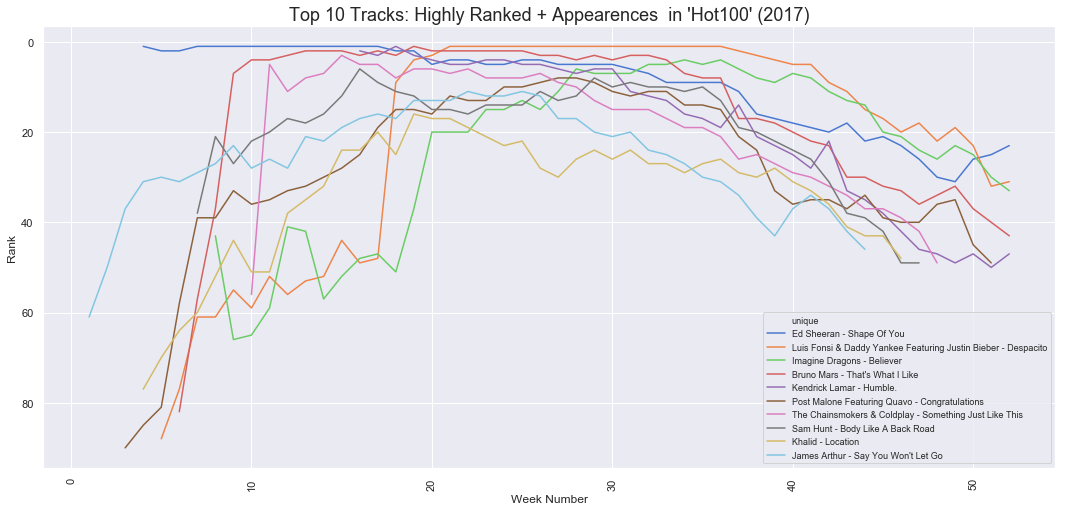

In [22]:
import calendar
sns.set(rc={'figure.figsize':(15,7.27)})
ax = sns.lineplot(x="week", y='rank', hue='unique', data=df_2017, palette="muted")
plt.gca().invert_yaxis()

#logit
plt.title("Top 10 Tracks: Highly Ranked + Appearences  in 'Hot100' (2017)", fontsize=18)
plt.xlabel('Week Number')
plt.ylabel('Rank')
plt.legend(loc='best', fontsize=9)
plt.xticks(rotation=90)
save_fig("HighR_manyApp_2017")
plt.show()

In [ ]:
billboard

spring_10 = df_spring[['Track Name', 'Position']].loc[df_spring.Position <= 10, :]




In [42]:
### 10 - Most total weeks on the Hot 100
mwh100 = billboard[billboard['rank']<=100]['unique'].value_counts()[:50]
billboard[billboard['unique'].isin(mwh100.index.values)].drop_duplicates('unique')

artist       date_  last_week_rank  \
2720                                   Ed Sheeran  2018-10-06            23.0   
4933                                       Avicii  2018-05-05             NaN   
5823                                   Ed Sheeran  2018-03-03            24.0   
8738            The Chainsmokers Featuring Halsey  2017-08-12            36.0   
11131                     Sia Featuring Sean Paul  2017-02-25            30.0   
16048          Wiz Khalifa Featuring Charlie Puth  2016-03-19            45.0   
16221            Mark Ronson Featuring Bruno Mars  2016-03-05             NaN   
17638                               WALK THE MOON  2015-11-28            38.0   
17644                                  Ed Sheeran  2015-11-28            41.0   
20649                                   Sam Smith  2015-05-02            49.0   
22742                                 John Legend  2014-12-06            36.0   
23248                Katy Perry Featuring Juicy J  2014-11-01            43.0   
23449                                 OneRepublic  2014-10-18            47.0   
24145                                    Bastille  2014-08-30            44.0   
24946                             Imagine Dragons  2014-07-05            45.0   
25748                             Imagine Dragons  2014-05-10            48.0   
26444                                  AWOLNATION  2014-03-22            41.0   
28549        Florida Georgia Line Featuring Nelly  2013-10-26            48.0   
29449                               The Lumineers  2013-08-24            44.0   
31548                                        fun.  2013-03-30            39.0   
31935                      Gotye Featuring Kimbra  2013-03-02            42.0   
32349                              Ellie Goulding  2013-02-02            49.0   
35148   LMFAO Featuring Lauren Bennett & GoonRock  2012-07-21            50.0   
36548                                       Adele  2012-04-14            43.0   
38342                              The Band Perry  2011-12-10            41.0   
44242                                       Train  2010-10-23            44.0   
44347                             Lady Antebellum  2010-10-16            46.0   
45648                         The Black Eyed Peas  2010-07-17            49.0   
47443                               Kings Of Leon  2010-03-13            44.0   
49647                                  Jason Mraz  2009-10-10            49.0   
59346                            Carrie Underwood  2007-12-01            43.0   
61947                                    The Fray  2007-06-02            43.0   
67748                                   Lifehouse  2006-04-22            45.0   
78546                             matchbox twenty  2004-03-27            49.0   
89143                                       Train  2002-03-16            45.0   
89545                                   Lifehouse  2002-02-16            48.0   
93344                                  Faith Hill  2001-05-26            45.0   
94045                                3 Doors Down  2001-04-07            42.0   
95845                                       Creed  2000-12-02            50.0   
96243                                  Faith Hill  2000-11-04            48.0   
97144                Santana Featuring Rob Thomas  2000-09-02            46.0   
97346                                    Lonestar  2000-08-19            45.0   
105245                                       Next  1999-02-13            48.0   
106423                                 Paula Cole  1998-11-21            47.0   
107018                                LeAnn Rimes  1998-10-10            48.0   
110320                                      Jewel  1998-02-21            42.0   
111323                               Duncan Sheik  1997-12-13            46.0   
115717                                Los Del Rio  1997-02-08            42.0   
118120                    Everything But The Girl  1996-08-24            4

In [204]:
# 10 - Most total weeks in the top ten
billboard[billboard['rank']<=10]['key'].value_counts()[:10]

Maroon 5 Featuring Cardi B Girls Like You                      33
Ed Sheeran Shape Of You                                        33
LeAnn Rimes How Do I Live                                      32
The Chainsmokers Featuring Halsey Closer                       32
Travis Scott Sicko Mode                                        32
Mark Ronson Featuring Bruno Mars Uptown Funk!                  31
Santana Featuring Rob Thomas Smooth                            30
LMFAO Featuring Lauren Bennett & GoonRock Party Rock Anthem    29
Bruno Mars That's What I Like                                  28
Jewel Foolish Games/You Were Meant For Me                      28
Name: key, dtype: int64

In [53]:
# most number 1 singles
billboard[billboard['rank']==1].drop_duplicates(['title'])


artist       date_  \
0                                  Post Malone & Swae Lee  2019-01-19   
100                                                Halsey  2019-01-26   
200                                         Ariana Grande  2019-02-02   
700                            Lady Gaga & Bradley Cooper  2019-03-09   
800                                        Jonas Brothers  2019-03-16   
1200                  Lil Nas X Featuring Billy Ray Cyrus  2019-04-13   
1300                                                Drake  2018-04-07   
1500                                                Drake  2018-04-21   
1600                                     Domenico Modugno  1958-08-16   
1682                                         The Elegants  1958-08-23   
2120                                        Tommy Edwards  1958-09-27   
2660                                        Conway Twitty  1958-11-08   
2746                                    The Kingston Trio  1958-11-15   
2925                                      The Teddy Bears  1958-11-29   
3193                     The Chipmunks With David Seville  1958-12-20   
3542                                         The Platters  1959-01-17   
3813                                          Lloyd Price  1959-02-07   
4177                                       Frankie Avalon  1959-03-07   
4616                                       The Fleetwoods  1959-04-11   
4963                                   Dave "Baby" Cortez  1959-05-09   
5056                                     Wilbert Harrison  1959-05-16   
5229                                        Johnny Horton  1959-05-30   
5760                                            Paul Anka  1959-07-11   
6116                   Elvis Presley With The Jordanaires  1959-08-08   
6298                                           The Browns  1959-08-22   
6652                                       Santo & Johnny  1959-09-19   
6832                                          Bobby Darin  1959-10-03   
7365                                       The Fleetwoods  1959-11-14   
7729                                         Guy Mitchell  1959-12-12   
7910                                       Frankie Avalon  1959-12-26   
7995                                        Marty Robbins  1960-01-02   
8178                                       Johnny Preston  1960-01-16   
8439                                         Mark Dinning  1960-02-06   
8617                        Percy Faith And His Orchestra  1960-02-20   
9422                   Elvis Presley With The Jordanaires  1960-04-23   
9776                                  The Everly Brothers  1960-05-21   
10214                                      Connie Francis  1960-06-25   
10397                                   Hollywood Argyles  1960-07-09   
10489                                          Brenda Lee  1960-07-16   
10756                                        Brian Hyland  1960-08-06   
10844                  Elvis Presley With The Jordanaires  1960-08-13   
11282                                      Chubby Checker  1960-09-17   
11374                                      Connie Francis  1960-09-24   
11557                                         Larry Verne  1960-10-08   
11639                                        The Drifters  1960-10-15   
11728                                          Brenda Lee  1960-10-22   
11991                                         Ray Charles  1960-11-12   
12077                      Maurice Williams & The Zodiacs  1960-11-19   
12168                  Elvis Presley With The Jordanaires  1960-11-26   
12688                    Bert Kaempfert And His Orchestra  1961-01-07   
12951                                       The Shirelles  1961-01-28   
13125                     Lawrence Welk And His Orchestra  1961-02-11   
13303                                      Chubby Checker  1961-02-25   
13558                  Elvis Presley With The Jordanaires  1961-03-18   
13732                               

In [109]:
billboard[billboard['rank']==1]['artist1'].value_counts()

Mariah Carey                                   79
The Beatles                                    59
Rihanna                                        43
Usher                                          41
Drake                                          39
Beyonce                                        36
Boyz II Men                                    34
Katy Perry                                     33
Madonna                                        32
Michael Jackson                                31
Whitney Houston                                31
The Black Eyed Peas                            28
Bee Gees                                       27
Elton John                                     27
Eminem                                         24
Adele                                          24
Diana Ross                                     23
Maroon 5                                       23
Santana                                        22
50 Cent                                        22


In [114]:
billboard['artist1'].value_counts()[:10]

Drake            1247
Taylor Swift      945
Rihanna           916
Elton John        886
Elvis Presley     880
Madonna           862
Kenny Chesney     845
Tim McGraw        813
Chris Brown       751
Usher             723
Name: artist1, dtype: int64

In [16]:
billboard[billboard['artist1']=='Drake']

artist       date_  \
1300                                             Drake  2018-04-07   
1400                                             Drake  2018-04-14   
1500                                             Drake  2018-04-21   
1501                                             Drake  2018-04-21   
248730                                           Drake  2009-05-23   
248808                                           Drake  2009-05-30   
248898                                           Drake  2009-06-06   
248956                                           Drake  2009-06-13   
249074                                           Drake  2009-06-20   
249165                                           Drake  2009-06-27   
249241                                           Drake  2009-07-04   
249341                                           Drake  2009-07-11   
249441                                           Drake  2009-07-18   
249540                                           Drake  2009-07-25   
249640                                           Drake  2009-08-01   
249727          Drake Featuring Trey Songz & Lil Wayne  2009-08-01   
249740                                           Drake  2009-08-08   
249818          Drake Featuring Trey Songz & Lil Wayne  2009-08-08   
249840                                           Drake  2009-08-15   
249913          Drake Featuring Trey Songz & Lil Wayne  2009-08-15   
249941                                           Drake  2009-08-22   
250003          Drake Featuring Trey Songz & Lil Wayne  2009-08-22   
250044                                           Drake  2009-08-29   
250100          Drake Featuring Trey Songz & Lil Wayne  2009-08-29   
250145                                           Drake  2009-09-05   
250201          Drake Featuring Trey Songz & Lil Wayne  2009-09-05   
250245                                           Drake  2009-09-12   
250292          Drake Featuring Trey Songz & Lil Wayne  2009-09-12   
250348                                           Drake  2009-09-19   
250391          Drake Featuring Trey Songz & Lil Wayne  2009-09-19   
250451                                           Drake  2009-09-26   
250486          Drake Featuring Trey Songz & Lil Wayne  2009-09-26   
250546  Drake Featuring Kanye West, Lil Wayne & Eminem  2009-10-03   
250552                                           Drake  2009-10-03   
250555          Drake Featuring Trey Songz & Lil Wayne  2009-10-03   
250578         Drake Featuring Lil Wayne & Young Jeezy  2009-10-03   
250650  Drake Featuring Kanye West, Lil Wayne & Eminem  2009-10-10   
250654                                           Drake  2009-10-10   
250659          Drake Featuring Trey Songz & Lil Wayne  2009-10-10   
250698         Drake Featuring Lil Wayne & Young Jeezy  2009-10-10   
250751  Drake Featuring Kanye West, Lil Wayne & Eminem  2009-10-17   
250759                                           Drake  2009-10-17   
250765          Drake Featuring Trey Songz & Lil Wayne  2009-10-17   
250806         Drake Featuring Lil Wayne & Young Jeezy  2009-10-17   
250853  Drake Featuring Kanye West, Lil Wayne & Eminem  2009-10-24   
250872          Drake Featuring Trey Songz & Lil Wayne  2009-10-24   
250875                                           Drake  2009-10-24   
250912         Drake Featuring Lil Wayne & Young Jeezy  2009-10-24   
250953  Drake Featuring Kanye West, Lil Wayne & Eminem  2009-10-31   
250974          Drake Featuring Trey Songz & Lil Wayne  2009-10-31   
250979                                           Drake  2009-10-31   
251012         Drake Featuring Lil Wayne & Young Jeezy  2009-10-31   
251052  Drake Featuring Kanye West, Lil Wayne & Eminem  2009-11-07   
251084          Drake Featuring Trey Songz & Lil Wayne  2009-11-07   
251110         Drake Featuring Lil Wayne & Young Jeezy  2009-11-07   
251155  Drake Featuring Kanye West, Lil Wayne & Eminem  2009-11-14   
251199          Drake Featuring Trey Songz & Lil Wayne  20

In [295]:
name =  'XXXTENTACION adfadfadfadfadf x Lil Pump Featuring Maluma'
def name_slicer(name):
    repls = {'X ' : 'Featuring', 'x ' : 'Featuring', '&' : 'Featuring', '+':'Featuring', ',':'Featuring', 'Feat.':'Featuring','With':'Featuring'}
    if name in ['Earth, Wind & Fire','Blood, Sweat & Tears']:
        pass
    else:
        name = reduce(lambda a, kv: a.replace(*kv), repls.items(), name)
        if 'Featuring' in name:
            name = name[:name.find("Featuring")-1]
    return name

name = name_slicer(name)
name

'XXXTENTACION adfadfadfadfadf'

In [297]:
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy
import pprint
import app_credentials
import json
from pandas.io.json import json_normalize

client_credentials_manager = SpotifyClientCredentials(client_id=app_credentials.client_id, client_secret=app_credentials.client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)


def get_artist(name):
    results = sp.search(q='artist:' + name, type='artist')
    items = results['artists']['items']
    if len(items) > 0:
        return items[0]
    else:
        return None

def get_artist_album_ids(name):
    artist = get_artist(name)
    results = sp.artist_albums(artist['id'], album_type='album', country='US')
    albums = results['items']
    album_ids = []
    album_ids[:] = [album['id'] for album in albums]
    return album_ids

def get_artist_features(name,ftrack,feature='valence'):
    # features: valence (default), acousticness, danceability,
    #           energy, instrumentalness, speechiness, & tempo
    run_once = 0
    d = dict()# initialize dictionary
    name = name_slicer(name)
    album_ids = get_artist_album_ids(name)
    features = []
    for album_id in album_ids:
        results = sp.album_tracks(album_id)
        tracks = results['items']
        for track in tracks:
            if(ftrack.lower() in track['name'].lower()):
                audioFeatures = sp.audio_features(track['id'])
#                 print(track['name']) # track name
#                 print(get_artist(name)['genres']) # ganre
#                 #result = (json_normalize(audioFeatures[0]))
#                 print(audioFeatures[0])
                  #features.append(audioFeatures[0])
                d = dict(zip(['artist','track','genres'],[name,track['name'],get_artist(name)['genres']]))
                d.update(audioFeatures[0])
                return d
            else:
                pass
    return d

ModuleNotFoundError: No module named 'spotipy'

In [6]:
# example format of the dictionary
exampleDict = {'artist': 'Ariana Grande',
 'track': 'thank u, next',
 'genres': ['dance pop', 'pop', 'post-teen pop'],
 'danceability': 0.717,
 'energy': 0.653,
 'key': 1,
 'loudness': -5.634,
 'mode': 1,
 'speechiness': 0.0658,
 'acousticness': 0.229,
 'instrumentalness': 0,
 'liveness': 0.101,
 'valence': 0.412,
 'tempo': 106.966,
 'type': 'audio_features',
 'id': '3e9HZxeyfWwjeyPAMmWSSQ',
 'uri': 'spotify:track:3e9HZxeyfWwjeyPAMmWSSQ',
 'track_href': 'https://api.spotify.com/v1/tracks/3e9HZxeyfWwjeyPAMmWSSQ',
 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/3e9HZxeyfWwjeyPAMmWSSQ',
 'duration_ms': 207320,
 'time_signature': 4}

In [19]:
# An Empty df_spotify
df_spotify = pd.DataFrame(columns=exampleDict.keys())


In [32]:
k = 0
for (i,j) in zip(billboard.artist,billboard.title): # getting artist & title
    if k>3:
        break
    else:
        try:
            a = get_artist_features(i,j)
            if not a:
                pass
            else:
                Series_ = pd.Series(a)
                df_spotify = df_spotify.append(Series_,ignore_index=True) 
            k+=1
        except:
            pass

In [195]:
# k = 0
# for l, (i,j) in enumerate(zip(billboard.artist,billboard.title)): # getting artist & title
#     if k>2:
#         break
#     else:
#         try:
#             df_spotify.loc[l] = list(get_artist_features(i,j).values())
#             k+=1
#         except:
#             pass

In [ ]:
# k = 0
# for (i,j) in zip(billboard.artist,billboard.title): # getting artist & title
#     if k>2:
#         break
#     else:
#         try:
#             Series_ = pd.Series(get_artist_features(i,j))
#             df_spotify = df_spotify.append(Series_,ignore_index=True) 
#             k+=1
#         except:
#             pass

In [26]:
test_df  = pd.DataFrame(columns=exampleDict.keys())

test_df.loc[1] = list(exampleDict.values())
test_df

artist          track                           genres  \
1  Ariana Grande  thank u, next  [dance pop, pop, post-teen pop]   

   danceability  energy key  loudness mode  speechiness  acousticness  ...  \
1         0.717   0.653   1    -5.634    1       0.0658         0.229  ...   

  liveness  valence    tempo            type                      id  \
1    0.101    0.412  106.966  audio_features  3e9HZxeyfWwjeyPAMmWSSQ   

                                    uri  \
1  spotify:track:3e9HZxeyfWwjeyPAMmWSSQ   

                                          track_href  \
1  https://api.spotify.com/v1/tracks/3e9HZxeyfWwj...   

                                        analysis_url duration_ms  \
1  https://api.spotify.com/v1/audio-analysis/3e9H...      207320   

  time_signature  
1              4  

[1 rows x 21 columns]

In [85]:
test_df.loc[1] = np.array(exampleDict.values())

ValueError: setting an array element with a sequence

In [87]:
test_df  = pd.DataFrame(columns=exampleDict.keys())

In [67]:
list(exampleDict.values())

['Ariana Grande',
 'thank u, next',
 ['dance pop', 'pop', 'post-teen pop'],
 0.717,
 0.653,
 1,
 -5.634,
 1,
 0.0658,
 0.229,
 0,
 0.101,
 0.412,
 106.966,
 'audio_features',
 '3e9HZxeyfWwjeyPAMmWSSQ',
 'spotify:track:3e9HZxeyfWwjeyPAMmWSSQ',
 'https://api.spotify.com/v1/tracks/3e9HZxeyfWwjeyPAMmWSSQ',
 'https://api.spotify.com/v1/audio-analysis/3e9HZxeyfWwjeyPAMmWSSQ',
 207320,
 4]

In [71]:
test_df

artist          track                           genres  \
0  Ariana Grande  thank u, next  [dance pop, pop, post-teen pop]   
1  Ariana Grande  thank u, next  [dance pop, pop, post-teen pop]   

   danceability  energy key  loudness mode  speechiness  acousticness  ...  \
0         0.717   0.653   1    -5.634    1       0.0658         0.229  ...   
1         0.717   0.653   1    -5.634    1       0.0658         0.229  ...   

  liveness  valence    tempo            type                      id  \
0    0.101    0.412  106.966  audio_features  3e9HZxeyfWwjeyPAMmWSSQ   
1    0.101    0.412  106.966  audio_features  3e9HZxeyfWwjeyPAMmWSSQ   

                                    uri  \
0  spotify:track:3e9HZxeyfWwjeyPAMmWSSQ   
1  spotify:track:3e9HZxeyfWwjeyPAMmWSSQ   

                                          track_href  \
0  https://api.spotify.com/v1/tracks/3e9HZxeyfWwj...   
1  https://api.spotify.com/v1/tracks/3e9HZxeyfWwj...   

                                        analysis_url duration_ms  \
0  https://api.spotify.com/v1/audio-analysis/3e9H...      207320   
1  https://api.spotify.com/v1/audio-analysis/3e9H...      207320   

  time_signature  
0              4  
1              4  

[2 rows x 21 columns]

In [44]:
for i in range(len(test_df)):
    for j in range(len(test_series)):
        test_df.loc[i,test_df.columns[j]] = test_series[j]

In [100]:
billboard.artist.count()

299099

In [39]:
for j in range(len(test_series)):
    print(test_series[j])

1
2
3


In [ ]:
k = 0
for (i,j) in zip(billboard.artist,billboard.title): # getting artist & title
    if k>1:
        break
    else:
        try:
            for indexx in range(billboard.artist.count()):
                list_ = list(get_artist_features(i,j).values())
                df_spotify.loc[indexx] = list_
                k+=1
        except:
            pass

From cffi callback <function _verify_callback at 0x000001A782382950>:
Traceback (most recent call last):
  File "c:\users\young min cho\python\python36\lib\site-packages\OpenSSL\SSL.py", line 306, in wrapper
    @wraps(callback)
KeyboardInterrupt
From cffi callback <function _verify_callback at 0x000001A7FBD2F7B8>:
Traceback (most recent call last):
  File "c:\users\young min cho\python\python36\lib\site-packages\OpenSSL\SSL.py", line 306, in wrapper
    @wraps(callback)
KeyboardInterrupt


In [31]:
test_series = pd.Series([1,2,3])

In [32]:
test_series

0    1
1    2
2    3
dtype: int64

In [23]:
test_df.iloc[:,2] = pd.Series([1,2,3])

In [90]:
sales = { 'apple': 2, 'orange': 3, 'grapes': 4 }

print(sales.items())

dict_items([('apple', 2), ('orange', 3), ('grapes', 4)])


In [278]:
df_spotify

artist                               track  \
0        Ariana Grande                       thank u, next   
1         Travis Scott                          SICKO MODE   
2  Panic! At The Disco                          High Hopes   
3             Maroon 5                      Girls Like You   
4          Kodak Black  ZEZE (feat. Travis Scott & Offset)   
5          Post Malone                          Better Now   

                             genres  danceability  energy key  loudness mode  \
0   [dance pop, pop, post-teen pop]         0.717   0.653   1    -5.634    1   
1   [pop, pop rap, rap, trap music]         0.834   0.730   8    -3.714    1   
2      [emo, modern rock, pop punk]         0.579   0.904   5    -2.729    1   
3                             [pop]         0.611   0.462   0    -7.054    1   
4  [miami hip hop, rap, trap music]         0.861   0.603   8    -5.788    0   
5                        [pop, rap]         0.680   0.563  10    -5.843    1   

   speechiness  acousticness  ... liveness  valence    tempo            type  \
0       0.0658       0.22900  ...   0.1010    0.412  106.966  audio_features   
1       0.2220       0.00513  ...   0.1240    0.446  155.008  audio_features   
2       0.0618       0.19300  ...   0.0640    0.681   82.014  audio_features   
3       0.0646       0.55800  ...   0.1310    0.377   59.635  audio_features   
4       0.1760       0.05210  ...   0.0924    0.504   98.043  audio_features   
5       0.0454       0.35400  ...   0.1360    0.374  145.028  audio_features   

                       id                                   uri  \
0  3e9HZxeyfWwjeyPAMmWSSQ  spotify:track:3e9HZxeyfWwjeyPAMmWSSQ   
1  2xLMifQCjDGFmkHkpNLD9h  spotify:track:2xLMifQCjDGFmkHkpNLD9h   
2  1rqqCSm0Qe4I9rUvWncaom  spotify:track:1rqqCSm0Qe4I9rUvWncaom   
3  6OEHjJJvdkk1Ln0p0AZdyz  spotify:track:6OEHjJJvdkk1Ln0p0AZdyz   
4  0FZ4Dmg8jJJAPJnvBIzD9z  spotify:track:0FZ4Dmg8jJJAPJnvBIzD9z   
5  7dt6x5M1jzdTEt8oCbisTK  spotify:track:7dt6x5M1jzdTEt8oCbisTK   

                                          track_href  \
0  https://api.spotify.com/v1/tracks/3e9HZxeyfWwj...   
1  https://api.spotify.com/v1/tracks/2xLMifQCjDGF...   
2  https://api.spotify.com/v1/tracks/1rqqCSm0Qe4I...   
3  https://api.spotify.com/v1/tracks/6OEHjJJvdkk1...   
4  https://api.spotify.com/v1/tracks/0FZ4Dmg8jJJA...   
5  https://api.spotify.com/v1/tracks/7dt6x5M1jzdT...   

                                        analysis_url duration_ms  \
0  https://api.spotify.com/v1/audio-analysis/3e9H...      207320   
1  https://api.spotify.com/v1/audio-analysis/2xLM...      312820   
2  https://api.spotify.com/v1/audio-analysis/1rqq...      190947   
3  https://api.spotify.com/v1/audio-analysis/6OEH...      215230   
4  https://api.spotify.com/v1/audio-analysis/0FZ4...      228760   
5  https://api.spotify.com/v1/audio-analysis/7dt6...      231267   

  time_signature  
0              4  
1              4  
2              4  
3              4  
4              4  
5              4  

[6 rows x 21 columns]

In [138]:
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy
import pprint
import app_credentials
import json
from pandas.io.json import json_normalize

client_credentials_manager = SpotifyClientCredentials(client_id=app_credentials.client_id, client_secret=app_credentials.client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)


def get_artist(name):
    results = sp.search(q='artist:' + name, type='artist')
    items = results['artists']['items']
    if len(items) > 0:
        return items[0]
    else:
        return None

def get_artist_album_ids(name):
    artist = get_artist(name)
    results = sp.artist_albums(artist['id'], album_type='album', country='US')
    albums = results['items']
    album_ids = []
    for album in albums:
        album_ids.append(album['id'])

    return album_ids

def get_artist_features(name, feature='valence'):
    # features: valence (default), acousticness, danceability,
    #           energy, instrumentalness, speechiness, & tempo
    if 'Featuring' in name:
        name = name[:name.find("Featuring")-1]
    album_ids = get_artist_album_ids(name)
    features = []
    for album_id in album_ids:
        results = sp.album_tracks(album_id)
        tracks = results['items']
        for track in tracks:
            audioFeatures = sp.audio_features(track['id'])
            print(track['name'])
            #print(json_normalize(audioFeatures))
            features.append(audioFeatures[0])

            
            #track['name']

            
    return None #features

In [139]:
get_artist_features("Ross Lynch")

In [76]:
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy
import pprint
import app_credentials
import json
from pandas.io.json import json_normalize

client_credentials_manager = SpotifyClientCredentials(client_id=app_credentials.client_id, client_secret=app_credentials.client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)


def get_artist(name):
    results = sp.search(q='artist:' + name, type='artist')
    items = results['artists']['items']
    if len(items) > 0:
        return items[0]
    else:
        return None

def get_artist_album_ids(name):
    artist = get_artist(name)
    results = sp.artist_albums(artist['id'], album_type='album', country='US')
    albums = results['items']
    album_ids = []
    for album in albums:
        album_ids.append(album['id'])

    return album_ids

def get_artist_features(name,ftrack,feature='valence'):
    # features: valence (default), acousticness, danceability,
    #           energy, instrumentalness, speechiness, & tempo
    run_once = 0
    if 'Featuring' in name:
        name = name[:name.find("Featuring")-1]
    album_ids = get_artist_album_ids(name)
    features = []
    for album_id in album_ids:
        results = sp.album_tracks(album_id)
        tracks = results['items']
        for track in tracks:
            if(ftrack.lower() in track['name'].lower() and run_once==0):
                audioFeatures = sp.audio_features(track['id'])
#                 print(track['name']) # track name
#                 print(get_artist(name)['genres']) # ganre
#                 #result = (json_normalize(audioFeatures[0]))
#                 print(audioFeatures[0])
                  #features.append(audioFeatures[0])
                d = dict() # initialize dictionary
                d['artist'] = name
                d['track'] = track['name']
                d['genres'] = get_artist(name)['genres']
                d.update(audioFeatures[0])

                run_once += 1 # run once
            else:
                pass
            

            
    return d

In [49]:
test_df.loc[0,'a']=1

In [51]:
test_df.loc[0] = [1,2,3]

In [69]:
test_df

artist          track                           genres  \
0  Ariana Grande  thank u, next  [dance pop, pop, post-teen pop]   

   danceability  energy key  loudness mode  speechiness  acousticness  ...  \
0         0.717   0.653   1    -5.634    1       0.0658         0.229  ...   

  liveness  valence    tempo            type                      id  \
0    0.101    0.412  106.966  audio_features  3e9HZxeyfWwjeyPAMmWSSQ   

                                    uri  \
0  spotify:track:3e9HZxeyfWwjeyPAMmWSSQ   

                                          track_href  \
0  https://api.spotify.com/v1/tracks/3e9HZxeyfWwj...   

                                        analysis_url duration_ms  \
0  https://api.spotify.com/v1/audio-analysis/3e9H...      207320   

  time_signature  
0              4  

[1 rows x 21 columns]

In [10]:
get_artist_features("Tory Lanez","Talk to me")

{'artist': 'Tory Lanez',
 'track': 'TAlk tO Me (with Rich The Kid)',
 'genres': ['canadian hip hop',
  'hip hop',
  'pop',
  'pop rap',
  'r&b',
  'rap',
  'southern hip hop',
  'trap music'],
 'danceability': 0.731,
 'energy': 0.657,
 'key': 0,
 'loudness': -8.56,
 'mode': 1,
 'speechiness': 0.0434,
 'acousticness': 0.0591,
 'instrumentalness': 0,
 'liveness': 0.0874,
 'valence': 0.49,
 'tempo': 159.97,
 'type': 'audio_features',
 'id': '2cRgo1TiPm7SnPvYzvbOLf',
 'uri': 'spotify:track:2cRgo1TiPm7SnPvYzvbOLf',
 'track_href': 'https://api.spotify.com/v1/tracks/2cRgo1TiPm7SnPvYzvbOLf',
 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/2cRgo1TiPm7SnPvYzvbOLf',
 'duration_ms': 184490,
 'time_signature': 4}

In [237]:
def list_to_list(row):
    return row.list